In [1]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
from matplotlib.backends.backend_pdf import PdfPages
import sys
import random
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import sys
sys.path.append('/home/almhatre/data')

#internal
from AGNclustering.kde import weighted_gaussian_kde
import AGNclustering.projected_correlation_functions as w
import AGNclustering.wppi_projected_correlation_functions as wz
import AGNclustering.BASS_randoms as rand
from AGNclustering.utils import wp_d1d2,wp_dd
from AGNclustering.wppi_utils import wppi_d1d2,wppi_dd,ratio_error,control_var,force_distributionmatch, control_mult_var

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)

agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN

agnt.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

Using sensitivity maps for 70 month survey


Set MJD-OBS to 53355.002572 from DATE-OBS.
Set MJD-END to 55469.117384 from DATE-END'. [astropy.wcs.wcs]


number of randoms: 55683


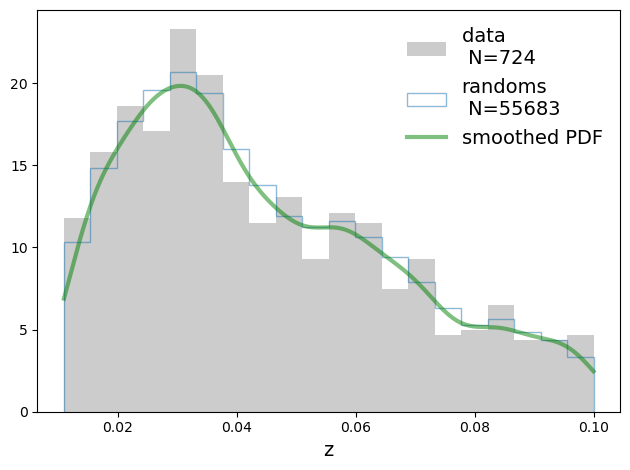

In [2]:
arand = rand.genrand(agn,100,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
                     data_path=data_directory,plot=True,plot_filename=None)
#100: 100X randoms as AGN

number of randoms: 887041


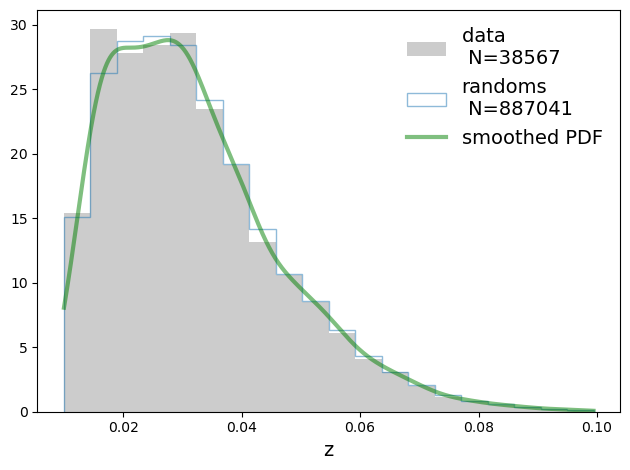

In [3]:
grandt = rand.genrand(gal,23,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=False,\
                     plot=True,plot_filename=None)

# exclude galactic plane:
gal = gal[(gal['b']<-8) | (gal['b']>8)]
grand = grandt[(grandt['b']<-8) | (grandt['b']>8)]

In [4]:
nonzero=agn['Mbh']!=0
agnmass=agn[nonzero]
# bins for wppi/wprp
ratiobins=np.arange(0,13,1,dtype=float)
ratiobins[0]=0.01
ratiopibins=np.arange(1,13,1)

pimax=40

# Different pibins
pibins = np.logspace(0,np.log10(40),6, dtype=int)
linpibins = np.arange(1,41,1)
pibinsmod = np.logspace(0,np.log10(40),3, dtype=int)
pibinsmod[0]=2
pibinsmod[1]=10

# Different rp bins
binsmod = np.logspace(0,np.log10(40),6,dtype=int)
binsmod = binsmod.astype(dtype=float)
binsmod = np.insert(binsmod, 0, 0.1)
binsmod = np.delete(binsmod,1)
binsmod = np.delete(binsmod,2)
binsmod[2]=10.0

linbins = np.arange(0,41,1, dtype=float)
linbins[0] = 0.01

nbins = 10
bins = np.logspace(-1, np.log10(40), nbins + 1)


# z space bins
stmin=np.min(agnmass['z'])
stmax=np.max(agnmass['z'])
increm=(0.100001-stmin)/9
zbins=np.arange(stmin,stmax+increm,increm)


stmin=np.min(agnmass['z'])
stmax=np.max(agnmass['z'])
increm=(0.100010-stmin)/5
zbinsmod=np.arange(stmin,stmax+increm,increm)

# stellar mass bin
stmin=np.min(agnmass['log_Ms'][agnmass['log_Ms']>8])
stmax=np.max(agnmass['log_Ms'][agnmass['log_Ms']>8])
increm=(stmax-stmin)/4
msbinsmod=np.arange(stmin,stmax+increm,increm)

increm=(stmax-stmin)/9
msbins=np.arange(stmin,stmax+increm,increm)

# percentage of each mass bin
percentile=33
print(zbins)

[0.011    0.020889 0.030778 0.040667 0.050556 0.060445 0.070334 0.080223
 0.090112 0.100001]


In [5]:
mumax=1.0
mubins=np.arange(0,1.1,.1)
sbins=np.logspace(-1,np.log10(40),11)


print(mubins)
print(sbins)
print(bins)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[ 0.1         0.18205642  0.3314454   0.60341763  1.09856054  2.
  3.64112841  6.62890803 12.06835267 21.97121087 40.        ]
[ 0.1         0.18205642  0.3314454   0.60341763  1.09856054  2.
  3.64112841  6.62890803 12.06835267 21.97121087 40.        ]


In [6]:
agnlowmass, agnmidmass, agnhighmass = control_var(agn=agnmass,bins=zbins,control='z',var='Mbh',percentile=percentile)


In [7]:
agnlowmass2,agnmidmass2,agnhighmass2=control_mult_var(agn=agnmass,bins1=zbins,bins2=msbinsmod,control1='z',control2='log_Ms',var='Mbh',percentile=percentile)


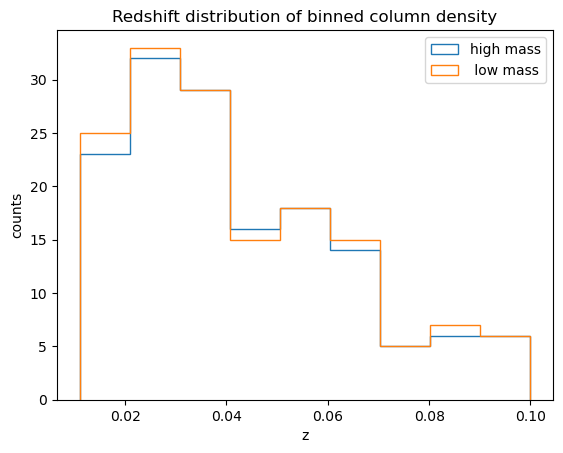

In [9]:
plt.hist(agnhighmass2['z'],bins=zbins,histtype='step',label='high mass')
plt.hist(agnlowmass2['z'],bins=zbins,histtype='step',label=' low mass')
graph=plt.title('Redshift distribution of binned column density')
plt.xlabel('z')
plt.ylabel('counts')
plt.legend()

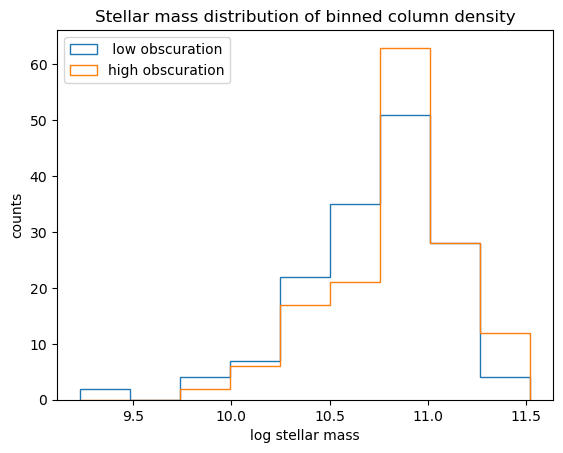

In [10]:
plt.hist(agnlowmass2['log_Ms'],bins=msbins,histtype='step',label=' low obscuration')
plt.hist(agnhighmass2['log_Ms'],bins=msbins,histtype='step',label='high obscuration')
graph=plt.title('Stellar mass distribution of binned column density')
plt.xlabel('log stellar mass')
plt.ylabel('counts')
plt.legend()

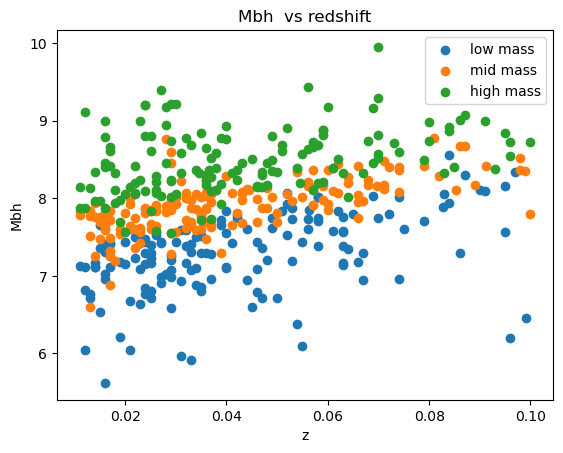

In [11]:
plt.scatter(agnlowmass2['z'],agnlowmass2['Mbh'],label='low mass')
plt.scatter(agnmidmass2['z'],agnmidmass2['Mbh'],label="mid mass")
plt.scatter(agnhighmass2['z'],agnhighmass2['Mbh'],label='high mass')
plt.xlabel('z')
plt.ylabel('Mbh')
plt.title('Mbh  vs redshift')
plt.legend()

In [15]:
%autoreload 2
sp_high,wpmu_high,wpmu_err_high,Mag = wz.cross_wpmu(d1=agnhighmass2, d2=gal, r1=arand, r2=grand, sbins=binsmod, mubins=mubins, mumax=mumax, m=5, estimator='P')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.084 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.060 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,26,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.060 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.060 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.059 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,26,14.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,26,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,28,14.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.......100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,14.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


In [16]:
sp_low,wpmu_low,wpmu_err_low,Mag = wz.cross_wpmu(d1=agnlowmass2, d2=gal, r1=arand, r2=grand, sbins=binsmod, mubins=mubins, mumax=mumax, m=5, estimator='P')


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 26,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.005 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,24,13.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.063 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,26,13.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,28,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.064 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,25,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,27,14.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.060 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,26,13.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 28,28,14.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


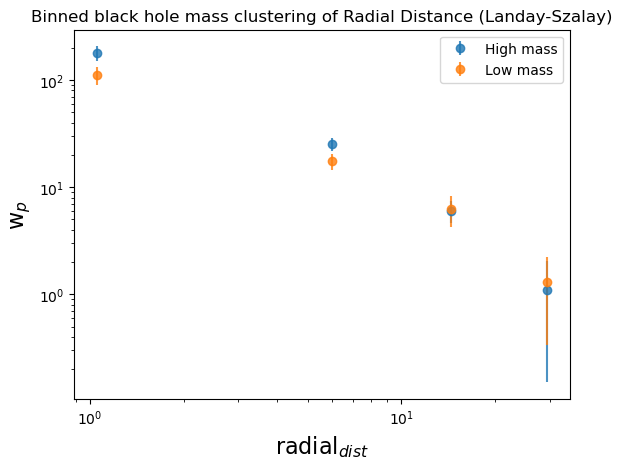

In [17]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(sp_high,wpmu_high,yerr=wpmu_err_high,fmt='o',label='High mass',alpha=0.8)
plt.errorbar(sp_low,wpmu_low,yerr=wpmu_err_low,fmt='o',label='Low mass',alpha=0.8)
plt.xlabel('radial$_{dist}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Binned black hole mass clustering of Radial Distance (Landay-Szalay)')
plt.legend()